<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/simulation/FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Python で有限要素法

[FEM on Colab](https://fem-on-colab.github.io/)　を利用

## NGSolve

In [1]:
try:
    import ngsolve
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/ngsolve-install.sh" -O "/tmp/ngsolve-install.sh" && bash "/tmp/ngsolve-install.sh"
    import ngsolve

--2023-09-13 11:27:23--  https://fem-on-colab.github.io/releases/ngsolve-install.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4190 (4.1K) [application/x-sh]
Saving to: ‘/tmp/ngsolve-install.sh’

/tmp/ngsolve-instal 100%[===================>]   4.09K  --.-KB/s    in 0s      

2023-09-13 11:27:23 (38.5 MB/s) - ‘/tmp/ngsolve-install.sh’ saved [4190/4190]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ NGSOLVE_INSTALLED=/usr/local/share/fem-on-colab/ngsolve.installed
+ [[ ! -f /usr/local/share/fem-on-colab/ngsolve.installed ]]
+ OCC_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/375c0fc/releases/occ-install.sh
+ 

### 正方領域のポアソン方程式

[First NGSolve example](https://docu.ngsolve.org/latest/i-tutorials/unit-1.1-poisson/poisson.html) に沿って正方領域のポアソン方程式を解く。
\begin{align}
    &-\Delta u=f\quad\text{@バルク中},\\
    &u=0\quad\text{@下辺および右辺},\\
    &\frac{∂u}{∂n}=0\quad\text{@上辺および左辺}
\end{align}

メッシュ生成 (maxh はメッシュの最大サイズ)

In [2]:
mesh = ngsolve.Mesh(ngsolve.unit_square.GenerateMesh(maxh=0.2))
print(type(mesh))
# number of vertices & elements
mesh.nv, mesh.ne

<class 'ngsolve.comp.Mesh'>


(39, 56)

In [3]:
from ngsolve.webgui import Draw

Draw(mesh)

要素空間を定義 (節点・要素の関係、要素の次数、境界条件)

In [4]:
fes = ngsolve.H1(mesh, order=2, dirichlet="bottom|right")
# 自由度
fes.ndof

133

要素空間の詳細

In [5]:
help(fes)

Help on H1 in module ngsolve.comp object:

class H1(FESpace)
 |  An H1-conforming finite element space.
 |  
 |  The H1 finite element space consists of continuous and
 |  element-wise polynomial functions. It uses a hierarchical (=modal)
 |  basis built from integrated Legendre polynomials on tensor-product elements,
 |  and Jaboci polynomials on simplicial elements. 
 |  
 |  Boundary values are well defined. The function can be used directly on the
 |  boundary, using the trace operator is optional.
 |  
 |  The H1 space supports variable order, which can be set individually for edges, 
 |  faces and cells. 
 |  
 |  Internal degrees of freedom are declared as local dofs and are eliminated 
 |  if static condensation is on.
 |  
 |  The wirebasket consists of all vertex dofs. Optionally, one can include the 
 |  first (the quadratic bubble) edge basis function, or all edge basis functions
 |  into the wirebasket.
 |  
 |  Keyword arguments can be:
 |  
 |  order: int = 1
 |    order

- $u$: 最適化に使用する試行関数 (Trial Function)
- $v$: 弱解を構成するための重み関数 (Test Function)
- gfu: 有限要素空間上の関数(解)と係数ベクトルを保有

In [6]:
u = fes.TrialFunction()  # symbolic object
v = fes.TestFunction()   # symbolic object
gfu = ngsolve.GridFunction(fes)  # solution

ポアソン方程式の弱解は形状関数$v(\in H^1_0(S))$を用いて
\begin{equation}
\begin{split}
    &-Δu=f \Rightarrow∫(-Δ u)vdS=∫fvdS \\
    &\Leftrightarrow
    \oint_{∂S}\left(-\sum_i∂_iu\cdot v\right)dl^i+∫\sum_i∂_iu∂_ivdS=∫fvdS.
\end{split}
\end{equation}
ただし１つ目の表面項を0にするような形状関数$v$を選ぶ。

In [7]:
from ngsolve import BilinearForm, LinearForm, grad, x, dx

# # old notations
# a = BilinearForm(fes, symmetric=True)
# a += grad(u) * grad(v) * dx
# a.Assemble()
# f = LinearForm(fes)
# f += x * v * dx
# f.Assemble()

a = BilinearForm(grad(u) * grad(v) * dx).Assemble()
f = LinearForm(x * v * dx).Assemble()

[Numpy Interface](https://docu.ngsolve.org/latest/how_to/howto_numpy.html?highlight=ngsolve%20la%20basevector) を使用してプロット

<class 'ngsolve.la.BaseVector'>


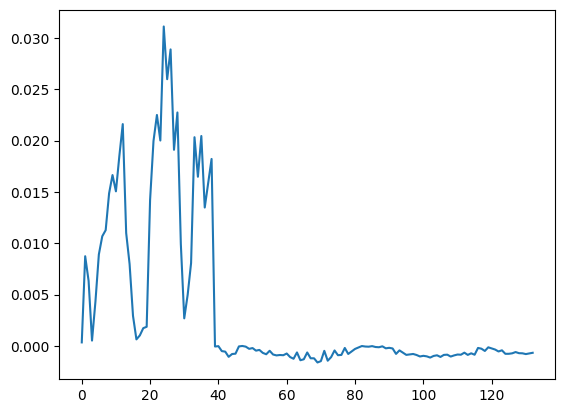

In [8]:
print(type(f.vec))

import matplotlib.pyplot as plt
plt.plot(f.vec.FV().NumPy())

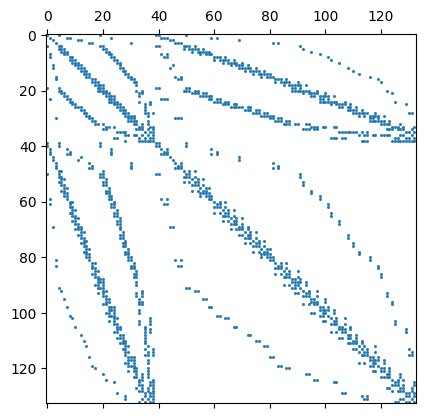

In [9]:
import scipy.sparse as sp

rows,cols,vals = a.mat.COO()
A = sp.csr_matrix((vals,(rows,cols)))

plt.spy(A, markersize=1)
plt.show()

In [10]:
gfu.vec.data = a.mat.Inverse(freedofs=fes.FreeDofs()) * f.vec

Draw(gfu)

<class 'ngsolve.la.BaseVector'>


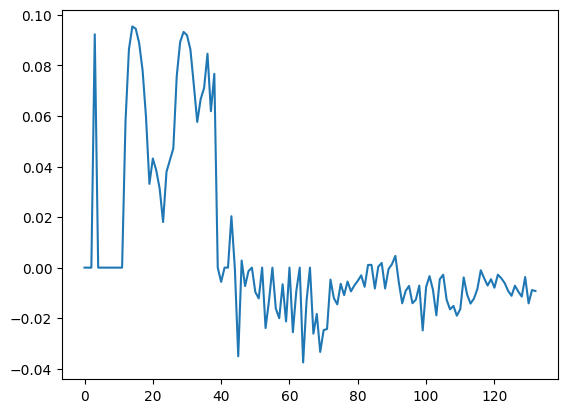

In [11]:
print(type(gfu.vec))
plt.plot(gfu.vec.FV().NumPy())

### 熱方程式

[Parabolic model problem](https://docu.ngsolve.org/latest/i-tutorials/unit-3.1-parabolic/parabolic.html)に従って時間依存性のある偏微分方程式である熱方程式を解く

変数と import をクリア

In [12]:
%reset -f

In [13]:
import ngsolve
from netgen.occ import Rectangle, X, Y, OCCGeometry

shape = Rectangle(2,2).Face().Move((-1,-1,0))
shape.edges.Min(X).name="left"
shape.edges.Max(X).name="right"
shape.edges.Min(Y).name="bottom"
shape.edges.Max(Y).name="top"
mesh = ngsolve.Mesh(OCCGeometry(shape, dim=2).GenerateMesh(maxh=0.25))

In [14]:
fes = ngsolve.H1(mesh, order=3, dirichlet="bottom|right|left|top")
u,v = fes.TnT()
time = 0.0
dt = 0.001

In [15]:
from ngsolve import x, y
from ngsolve.webgui import Draw

b = ngsolve.CoefficientFunction((2*y*(1-x*x),-2*x*(1-y*y)))
Draw(b,mesh,"wind", vectors={"grid_size": 32}, order=3)

In [16]:
from ngsolve import grad, dx

#a = ngsolve.BilinearForm(fes, symmetric=False)
#a += 0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx
#a.Assemble()
#m = ngsolve.BilinearForm(fes, symmetric=False)
#m += u*v*dx
#m.Assemble()

a = ngsolve.BilinearForm(0.01*grad(u)*grad(v)*dx + b*grad(u)*v*dx).Assemble()
m = ngsolve.BilinearForm(u*v*dx).Assemble()

In [28]:
mstar = m.mat.CreateMatrix()
print(f"m.mat.nze = {m.mat.nze}, a.mat.nze={a.mat.nze}, mstar.nze={mstar.nze}")
print(type(mstar))

m.mat.nze = 11257, a.mat.nze=11257, mstar.nze=11257
<class 'ngsolve.la.SparseMatrixd'>


In [29]:
print(f"mstar.nze={mstar.nze}, len(mstar.AsVector())={len(mstar.AsVector())}")

mstar.nze=11257, len(mstar.AsVector())=11257


In [26]:
print(mstar.AsVector())

AttributeError: ignored

In [20]:
mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
# corresponds to M* = M + dt * A
invmstar = mstar.Inverse(freedofs=fes.FreeDofs())

In [21]:
f = ngsolve.LinearForm(fes)
gaussp = ngsolve.exp(-6*((x+0.5)*(x+0.5)+y*y))-ngsolve.exp(-6*((x-0.5)*(x-0.5)+y*y))
Draw(gaussp,mesh,"f", deformation=True)
f += gaussp*v*dx
f.Assemble()

In [22]:
gfu = ngsolve.GridFunction(fes)
gfu.Set((1-y*y)*x) # note that boundary conditions remain
scene = Draw(gfu,mesh,"u")

In [23]:
def TimeStepping(invmstar, initial_cond = None, t0 = 0, tend = 2,
                 nsamples = 10):
    if initial_cond:
        gfu.Set(initial_cond)
    cnt = 0; time = t0
    sample_int = int(ngsolve.floor(tend / dt / nsamples)+1)
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)
    gfut.AddMultiDimComponent(gfu.vec)
    while time < tend - 0.5 * dt:
        res = dt * f.vec - dt * a.mat * gfu.vec
        gfu.vec.data += invmstar * res
        print("\r",time,end="")
        if cnt % sample_int == 0:
            gfut.AddMultiDimComponent(gfu.vec)
        cnt += 1; time = cnt * dt
    return gfut

In [24]:
%%time
gfut = TimeStepping(invmstar, (1-y*y)*x)

 1.999CPU times: user 2.97 s, sys: 183 ms, total: 3.15 s
Wall time: 3.26 s


In [25]:
Draw(gfut, mesh, interpolate_multidim=True, animate=True)